<a href="https://colab.research.google.com/github/OliviaHelena10/skincare_recommendations/blob/main/Colab_Predict_Skins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [2]:
# Basic DS libraries
import pandas as pd
import numpy as np

# Will help to list our files
from glob import glob
import pathlib
import PIL

# Will help us with the images
import cv2
import os
import tensorflow as tf
import matplotlib.pyplot as plt

# Organising our Data

 Getting our data path:

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Here we are accessing our data from google drive
path_train = '/content/drive/MyDrive/skin_search/train'
path_test = '/content/drive/MyDrive/skin_search/test'
path_validation = '/content/drive/MyDrive/skin_search/valid'

Saving the paths in variables:

In [4]:
train_dir = pathlib.Path(path_train)
test_dir = pathlib.Path(path_test)
validation_dir = pathlib.Path(path_validation)

Checking the categories:

In [5]:
path = '/content/drive/MyDrive/skin_search/train'
data_dir = pathlib.Path(path)


# Iterating through the train subfolders and getting their names just in case
train_subfolders = [f.name for f in data_dir.iterdir() if f.is_dir()]
print(f'train: {train_subfolders}')

train: ['normal', 'oily', 'dry']


In [6]:
for subfolder in train_subfolders:
  path =  train_dir / subfolder
  images = list(path.glob('*.jpg'))
  print(f'{subfolder}: {len(images)} imagens')

normal: 1114 imagens
oily: 1010 imagens
dry: 662 imagens


In [7]:
# Checking our Datas

for subfolder in train_subfolders:                # iterates through the subfolders: dry, normal and oily
  path =  train_dir / subfolder                   # gets the path of each image
  images = list(path.glob('*.jpg'))               # gets the images of each subfolder
  print(f'\n{subfolder}: {len(images)} imagens')  # prints the number of data in each subfolder

  if images:
    img = PIL.Image.open(str(images[0]))          # opens the first image in the list
    img_array = np.array(img)                     # converts the image to a numpy array
    print(f'dimensões da primeira imagem em {subfolder} : {img_array.shape}\n') # gets our image dimensions
  print("------------------------------------------------------")


normal: 1114 imagens
dimensões da primeira imagem em normal : (640, 640, 3)

------------------------------------------------------

oily: 1010 imagens
dimensões da primeira imagem em oily : (640, 640, 3)

------------------------------------------------------

dry: 662 imagens
dimensões da primeira imagem em dry : (640, 640, 3)

------------------------------------------------------


# Image preprocessing for model training

Defining Variables:

In [8]:
# We must maintain tha same proportions of the images width and height
image_width = 640
image_height = 640


# Images always have 3 color dimensions RGB pr BGR        ( R for Red  -  G for Green  -  B for Blue )
image_color_channel = 3
image_color_channel_size = 255
image_size = (image_width, image_height)
img_shape = image_size + (image_color_channel,)

batch_size = 16            # number of features that I will bring at a time from my dataset
epocas = 32                 # number of times that I will iterate trought my dataset
learning_rate = 0.0001

class_names = ['dry', 'normal', 'oily']

Separating train, test and validation data

In [9]:
train = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed = 568,         # this will get random weights for the transformations
    image_size = (image_height,image_width),
    batch_size = batch_size
)

Found 2787 files belonging to 3 classes.


In [10]:
test = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed = 568,         # this will get random weights for the transformations
    image_size = (image_height,image_width),
    batch_size = batch_size
)


Found 134 files belonging to 3 classes.


In [11]:
validation = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    seed = 568,         # this will get random weights for the transformations
    image_size = (image_height,image_width),
    batch_size = batch_size
)

Found 262 files belonging to 3 classes.


# Creating a Machine Learning Supervised Learning model - type Image Classification

In [68]:
tf.random.set_seed(245)

In [69]:
model = tf.keras.models.Sequential([

    # Input:
    tf.keras.layers.Input(shape=(640, 640,  3)),                                # This are the dimensions from our input data

    # Reescaling Layers
    tf.keras.layers.Rescaling(1./255),                                          # Normalizing our data by reescaling the pixels

    # Padding Layers
    tf.keras.layers.Flatten(),                                                  # Flattening our data to 1 dimension

    # Hidden Layers:
    tf.keras.layers.Dense(128,activation=tf.nn.relu),                           # Dense Layer will do the "math" for getting our results

    # Output:
    tf.keras.layers.Dense(3, activation=tf.nn.softmax)                          # Softmax activation is used for cathegorical data and 3 are the dimensions in our dataset
])

In [70]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_10 (Rescaling)             │ (None, 640, 640, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 1228800)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 128)                 │     157,286,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 157,286,915 (600.00 MB)

 Trainable params: 157,286,915 (600.00 MB)

 Non-trainable params: 0 (0.00 B)

In [71]:
model.compile(optimizer = tf.keras.optimizers.Adam(),           # Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments
              loss='sparse_categorical_crossentropy',           # Will show the lesses of our training
              metrics=['accuracy'])                             # List of metrics to be evaluated by the model during training and testing.

In [72]:
epocas = 32

history = model.fit(
    train,
    validation_data = validation,
    epochs = epocas # quantity of iterations
)

Epoch 1/32
175/175 ━━━━━━━━━━━━━━━━━━━━ 24s 122ms/step - accuracy: 0.3406 - loss: 230.4680 - val_accuracy: 0.4122 - val_loss: 102.7572
Epoch 2/32
175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.4102 - loss: 73.5432 - val_accuracy: 0.4160 - val_loss: 85.9863
Epoch 3/32
175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - accuracy: 0.4450 - loss: 64.4490 - val_accuracy: 0.2863 - val_loss: 29.9755
Epoch 4/32
175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 95ms/step - accuracy: 0.4991 - loss: 22.1883 - val_accuracy: 0.4008 - val_loss: 44.6056
Epoch 5/32
175/175 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - accuracy: 0.4914 - loss: 24.2647 - val_accuracy: 0.3740 - val_loss: 16.9641
Epoch 6/32
175/175 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step - accuracy: 0.5618 - loss: 12.2360 - val_accuracy: 0.3550 - val_loss: 13.1035
Epoch 7/32
175/175 ━━━━━━━━━━━━━━━━━━━━ 29s 144ms/step - accuracy: 0.5486 - loss: 11.9413 - val_accuracy: 0.2939 - val_loss: 17.1018
Epoch 8/32
175/175 ━━━━━━━━━━━━━━━━━━━━ 32s 93ms/step - accuracy: 0.583

In [73]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

quant_tflite_model = converter.convert()

Saved artifact at '/tmp/tmp474fx4tj'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 640, 640, 3), dtype=tf.float32, name='keras_tensor_68')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  133245355213920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133245355220960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133245355219904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133245355222544: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [77]:
with open('quant_model16bits.tflite', 'wb') as f:
    f.write(quant_tflite_model)

# Plotting our results in graphics

In [19]:
def plot_results(history, epocas):

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss =  history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epocas)

  plt.figure(figsize=(12, 6))
  plt.subplot(1,2,1)
  plt.plot(epochs_range, acc, 'r', label='Train accuracy')
  plt.plot(epochs_range, val_acc, 'b', label='Validation accuracy')
  plt.legend(loc = 'lower right')

  plt.subplot(1,2,2)

  plt.plot(epochs_range, loss, 'r', label = 'Train Loss')
  plt.plot(epochs_range, val_loss, 'b', label = 'Validation Loss')
  plt.legend(loc = 'upper right')

  plt.show()

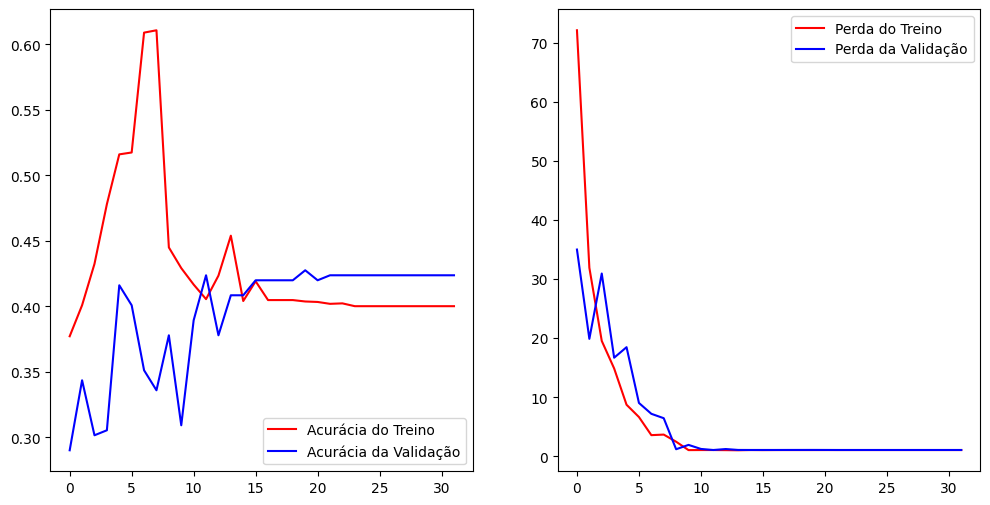

In [43]:
plot_results(history,epocas)

Here we have low results for validation and train, this can be because our model is too simple or because we have a bad data so our model couldn't leanr properly.

## Elaborated model


In [63]:
tf.random.set_seed(250)

In [64]:
model2 = tf.keras.models.Sequential([

    # Input:
    tf.keras.layers.Input(shape=(640, 640,  3)),                                # This are the dimensions from our input data

    # Reescaling Layers:
    tf.keras.layers.Rescaling(1./255),                                          # Normalizing our data by reescaling the pixels

    # Hidden Layer 1:
    tf.keras.layers.Conv2D(4, (3,3), activation = tf.nn.relu),                 # This layers will apply filters with a convolutional network
                                                                                # 3,3 --> pixels          32 --> numver of differents types of filters
    # Reducing Layer:
    tf.keras.layers.MaxPooling2D(2,2),                                          # This layers will reduce the dimensionality of the feature maps

    # Flattening Layers:
    tf.keras.layers.Flatten(),                                                  # Flattening our data to 1 dimension

    # Hidden Layer 2:
    tf.keras.layers.Dense(128,activation=tf.nn.relu),                           # Dense Layer will do the "math" for getting our results

    # Output:
    tf.keras.layers.Dense(3, activation=tf.nn.softmax)                          # Softmax activation is used for cathegorical data and 3 are the dimensions in our dataset
])

In [65]:
model2.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [61]:
epocas = 20

history = model2.fit(
    train,
    validation_data = validation,
    epochs = epocas
)

Epoch 1/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.3768 - loss: 111.9992 - val_accuracy: 0.2977 - val_loss: 9.4889
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 100ms/step - accuracy: 0.5478 - loss: 3.1417 - val_accuracy: 0.3550 - val_loss: 1.5327
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 17s 98ms/step - accuracy: 0.8320 - loss: 0.4444 - val_accuracy: 0.3664 - val_loss: 1.5304
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 95ms/step - accuracy: 0.9093 - loss: 0.2372 - val_accuracy: 0.3626 - val_loss: 1.5788
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 22s 101ms/step - accuracy: 0.9376 - loss: 0.1647 - val_accuracy: 0.4198 - val_loss: 1.9682
Epoch 6/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/step - accuracy: 0.9603 - loss: 0.1079 - val_accuracy: 0.3702 - val_loss: 2.0785
Epoch 7/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 22s 103ms/step - accuracy: 0.9838 - loss: 0.0611 - val_accuracy: 0.3931 - val_loss: 2.4033
Epoch 8/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/step - accuracy: 0.9878 - loss: 0.0

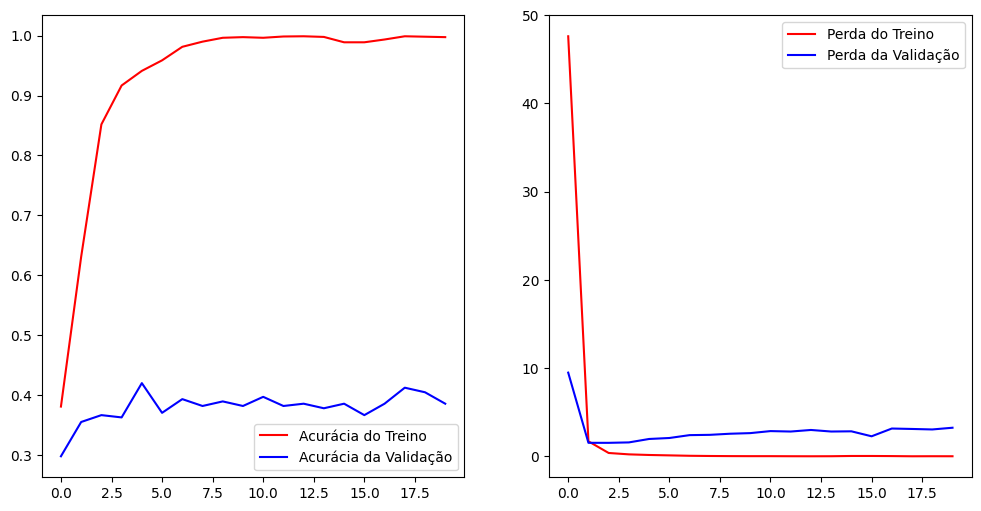

In [62]:
plot_results(history,epocas)

In this case we have a good train result, but the validation accuracy is too low. Our model was a little bit more elaborated but our results are worst then on the first model.

## Stopping the model before it ends

In [66]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') >= 0.94):
      print("\n Alcançamos 94% de acurácia. Parando o treinamento!")
      self.model.stop_training = True

callbacks = myCallback()

In [67]:
epocas = 30

history = model2.fit(
    train,
    validation_data = validation,
    epochs = epocas,
    callbacks=[callbacks]
)

Epoch 1/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 22s 109ms/step - accuracy: 0.3896 - loss: 30.7962 - val_accuracy: 0.3931 - val_loss: 2.5339
Epoch 2/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 100ms/step - accuracy: 0.7073 - loss: 0.7580 - val_accuracy: 0.3168 - val_loss: 1.3376
Epoch 3/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 91ms/step - accuracy: 0.9207 - loss: 0.2781 - val_accuracy: 0.3702 - val_loss: 1.4523
Epoch 4/30
174/175 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9656 - loss: 0.1584
 Alcançamos 94% de acurácia. Parando o treinamento!
175/175 ━━━━━━━━━━━━━━━━━━━━ 22s 99ms/step - accuracy: 0.9656 - loss: 0.1582 - val_accuracy: 0.3779 - val_loss: 1.5711


Here we can see that our validation results are still bad. We can conffirm now that the problem is in our input data that probably have low qualitity.
For the time being we are going to use the first model, but we still pretend to clean that data in order to achieve better results.

In [80]:
print('hello')

hello
